In [127]:
import pandas as pd
from preprocessing.light.text_cleaner_light import TextCleaner
from preprocessing.text_tokenizer import TextTokenizer
from preprocessing.light.text_lemmatizer_light import TextLemmatizer
from preprocessing.light.stopword_remover_light import StopwordRemover
import torch
import torch.nn as nn
from embedding.fasttext import FastText
import nltk
import os

from bs4 import MarkupResemblesLocatorWarning
import warnings

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

nltk_dir = 'nltk_data'
nltk.data.path.append(os.path.abspath(nltk_dir))

In [128]:
df = pd.read_csv('./data/sentiment_data.csv')

In [129]:
df.head()

,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2


In [130]:
df_shortened = df.sample(n=1000)
df_shortened.head()

,Unnamed: 0,Comment,Sentiment
240765,241546,many pakoda sellers need enough pakoda sellers...,2
67785,68562,raining im outside without umbrella,1
81893,82671,perfect reasons vote modi prime minister,2
9805,9835,ewic mukbang promoting small businesses napa s...,2
160965,161743,looks like authentic see modi haters even powe...,2


# Preprocessing

In [131]:
TextCleaner = TextCleaner()
df_cleaned = df_shortened.copy()
for index, row in df_shortened.iterrows():
    df_cleaned.at[index, 'Comment'] = TextCleaner.clean_text(row['Comment'])

df_cleaned.head()

,Unnamed: 0,Comment,Sentiment
240765,241546,many pakoda sellers need enough pakoda sellers...,2
67785,68562,raining im outside without umbrella,1
81893,82671,perfect reasons vote modi prime minister,2
9805,9835,ewic mukbang promoting small businesses napa s...,2
160965,161743,looks like authentic see modi haters even powe...,2


In [132]:
TextTokenizer = TextTokenizer()
df_tokenised = df_cleaned.copy()
for index, row in df_cleaned.iterrows():
    df_tokenised.at[index, 'Comment'] = TextTokenizer.tokenize(row['Comment'])

df_tokenised.head()

,Unnamed: 0,Comment,Sentiment
240765,241546,"[many, pakoda, sellers, need, enough, pakoda, ...",2
67785,68562,"[raining, im, outside, without, umbrella]",1
81893,82671,"[perfect, reasons, vote, modi, prime, minister]",2
9805,9835,"[ewic, mukbang, promoting, small, businesses, ...",2
160965,161743,"[looks, like, authentic, see, modi, haters, ev...",2


In [133]:
StopwordRemover = StopwordRemover()
df_stopwords_removed = df_tokenised.copy()
for index, row in df_tokenised.iterrows():
    df_stopwords_removed.at[index, 'Comment'] = StopwordRemover.remove_stopwords(row['Comment'])

df_stopwords_removed.head()

,Unnamed: 0,Comment,Sentiment
240765,241546,"[many, pakoda, sellers, need, enough, pakoda, ...",2
67785,68562,"[raining, im, outside, without, umbrella]",1
81893,82671,"[perfect, reasons, vote, modi, prime, minister]",2
9805,9835,"[ewic, mukbang, promoting, small, businesses, ...",2
160965,161743,"[looks, like, authentic, see, modi, haters, ev...",2


In [134]:
TextLemmatizer = TextLemmatizer()
df_lemmatised = df_stopwords_removed.copy()
for index, row in df_stopwords_removed.iterrows():
    df_lemmatised.at[index, 'Comment'] = TextLemmatizer.lemmatize(row['Comment'])

df_lemmatised.head()

,Unnamed: 0,Comment,Sentiment
240765,241546,"[many, pakoda, selers, ned, enough, pakoda, se...",2
67785,68562,"[rain, im, outside, without, umbrela]",1
81893,82671,"[perfect, reason, vote, modi, prime, minister]",2
9805,9835,"[ewic, mukbang, promote, smal, busineses, napa...",2
160965,161743,"[loks, like, authentic, see, modi, hater, even...",2


In [135]:
empty_comments = df_lemmatised[df_lemmatised['Comment'].apply(lambda x: len(x) == 0)]
print("Number of empty comments:", len(empty_comments))

if len(empty_comments) > 0:
	print("\nEmpty comments found at indices:")
	print(empty_comments.index.tolist())

df_lemmatised = df_lemmatised[df_lemmatised['Comment'].apply(lambda x: len(x) > 0)]

empty_comments = df_lemmatised[df_lemmatised['Comment'].apply(lambda x: len(x) == 0)]
print("Number of empty comments:", len(empty_comments))

if len(empty_comments) > 0:
	print("\nEmpty comments found at indices:")

Number of empty comments: 1

Empty comments found at indices:
[45425]
Number of empty comments: 0


In [136]:
all_tokens = []
for index, row in df_lemmatised.iterrows():
	all_tokens.extend(row['Comment'])

vocab = set(all_tokens)
vocab_to_idx = {'<PAD>': 0, '<UNK>': 1}
for token in vocab:
	vocab_to_idx[token] = len(vocab_to_idx)

idx_to_vocab = {idx: token for token, idx in vocab_to_idx.items()}

print(f"Vocabulary size: {len(vocab_to_idx)}")
print("Sample tokens:", list(vocab_to_idx.keys())[:10])

Vocabulary size: 4520
Sample tokens: ['<PAD>', '<UNK>', 'restrict', 'scream', 'indiathey', 'nepal', 'tibetel', 'constructive', 'clock', 'fast']


In [137]:
def tokens_to_indices(tokens, vocab_to_idx):
	return [vocab_to_idx.get(token, vocab_to_idx['<UNK>']) for token in tokens]

df_indices = df_lemmatised.copy()
for index, row in df_lemmatised.iterrows():
	df_indices.at[index, 'Comment'] = tokens_to_indices(row['Comment'], vocab_to_idx)

In [138]:
def pad_sequences(sequences, max_len, pad_value=0):
	padded = []
	for seq in sequences:
		if len(seq) > max_len:
			padded.append(seq[:max_len])
		else:
			padded.append(seq + [pad_value] * (max_len - len(seq)))
	return padded

sequence_lengths = [len(seq) for seq in df_indices['Comment']]
max_len = max(sequence_lengths)
avg_len = sum(sequence_lengths) / len(sequence_lengths)

print(f"Max sequence length: {max_len}")
print(f"Average sequence length: {avg_len:.2f}")

import numpy as np
chosen_max_len = int(np.percentile(sequence_lengths, 95))
print(f"Chosen max length (95th percentile): {chosen_max_len}")

padded_sequences = pad_sequences(df_indices['Comment'].tolist(), chosen_max_len, vocab_to_idx['<PAD>'])

print(f"Padded sequences shape: {len(padded_sequences)} x {len(padded_sequences[0])}")

Max sequence length: 65
Average sequence length: 12.95
Chosen max length (95th percentile): 27
Padded sequences shape: 999 x 27


In [139]:
from sklearn.model_selection import train_test_split

X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(df_indices['Sentiment'].values, dtype=torch.long)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of classes: {len(torch.unique(y))}")
print(f"Classes distribution: {torch.bincount(y)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validation set: X_val {X_val.shape}, y_val {y_val.shape}")

X shape: torch.Size([999, 27])
y shape: torch.Size([999])
Number of classes: 3
Classes distribution: tensor([245, 334, 420])
Training set: X_train torch.Size([799, 27]), y_train torch.Size([799])
Validation set: X_val torch.Size([200, 27]), y_val torch.Size([200])


# RNN Architecture (From Scratch)


In [140]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        #  Poids pour l'entrée
        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size))

        # Poids pour l'état caché
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size)) # W_hh = W_hh^T

        # Biais
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

        # Couche de sortie
        self.fc = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h_t = torch.zeros(batch_size, self.hidden_size)

        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t = torch.tanh(x_t @ self.W_xh + h_t @ self.W_hh + self.b_h)

        output = self.fc(h_t)
        return output

In [141]:
class SentimentRNN(nn.Module):
	def __init__(self, vocab_size, input_size, hidden_size, num_classes):
		super(SentimentRNN, self).__init__()
		self.hidden_size = hidden_size
		
		# Couche d'embedding
		self.embedding = nn.Embedding(vocab_size, input_size)
		
		# RNN simple
		self.rnn = SimpleRNN(input_size, hidden_size, num_classes)
		
	def forward(self, x):
		embedded = self.embedding(x)
		
		output = self.rnn(embedded)
		
		return output

# Paramètres du modèle
vocab_size = len(vocab_to_idx)
input_size = 64
hidden_size = 32
num_classes = 3

model = SentimentRNN(vocab_size, input_size, hidden_size, num_classes)

# Training


In [142]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report

learning_rate = 0.001
batch_size = 32
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [143]:
def train_epoch(model, train_loader, criterion, optimizer):
	model.train()
	total_loss = 0
	total_correct = 0
	total_samples = 0
	
	for batch_idx, (data, target) in enumerate(train_loader):
		optimizer.zero_grad()
		
		# Forward pass
		output = model(data)
		loss = criterion(output, target)
		
		# Backward pass
		loss.backward()
		optimizer.step()
		
		# Statistiques
		total_loss += loss.item()
		pred = output.argmax(dim=1)
		total_correct += (pred == target).sum().item()
		total_samples += target.size(0)
	
	avg_loss = total_loss / len(train_loader)
	accuracy = total_correct / total_samples
	return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion):
	model.eval()
	total_loss = 0
	total_correct = 0
	total_samples = 0
	
	with torch.no_grad():
		for data, target in val_loader:
			output = model(data)
			loss = criterion(output, target)
			
			total_loss += loss.item()
			pred = output.argmax(dim=1)
			total_correct += (pred == target).sum().item()
			total_samples += target.size(0)
	
	avg_loss = total_loss / len(val_loader)
	accuracy = total_correct / total_samples
	return avg_loss, accuracy


In [144]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
	train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
	
	val_loss, val_acc = validate_epoch(model, val_loader, criterion)
	
	train_losses.append(train_loss)
	train_accuracies.append(train_acc)
	val_losses.append(val_loss)
	val_accuracies.append(val_acc)
	
	if (epoch + 1) % 5 == 0 or epoch == 0:
		print(f"Époque [{epoch+1:2d}/{num_epochs}] | "
			  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
			  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("Entraînement terminé!")

Début de l'entraînement...
Époque [ 1/20] | Train Loss: 1.0818 | Train Acc: 0.3692 | Val Loss: 1.0752 | Val Acc: 0.4050
Époque [ 5/20] | Train Loss: 1.0596 | Train Acc: 0.4406 | Val Loss: 1.0764 | Val Acc: 0.3950
Époque [10/20] | Train Loss: 1.0491 | Train Acc: 0.4305 | Val Loss: 1.0854 | Val Acc: 0.4100
Époque [15/20] | Train Loss: 1.0460 | Train Acc: 0.4593 | Val Loss: 1.0791 | Val Acc: 0.3900
Époque [20/20] | Train Loss: 1.0358 | Train Acc: 0.4355 | Val Loss: 1.0823 | Val Acc: 0.4050
Entraînement terminé!


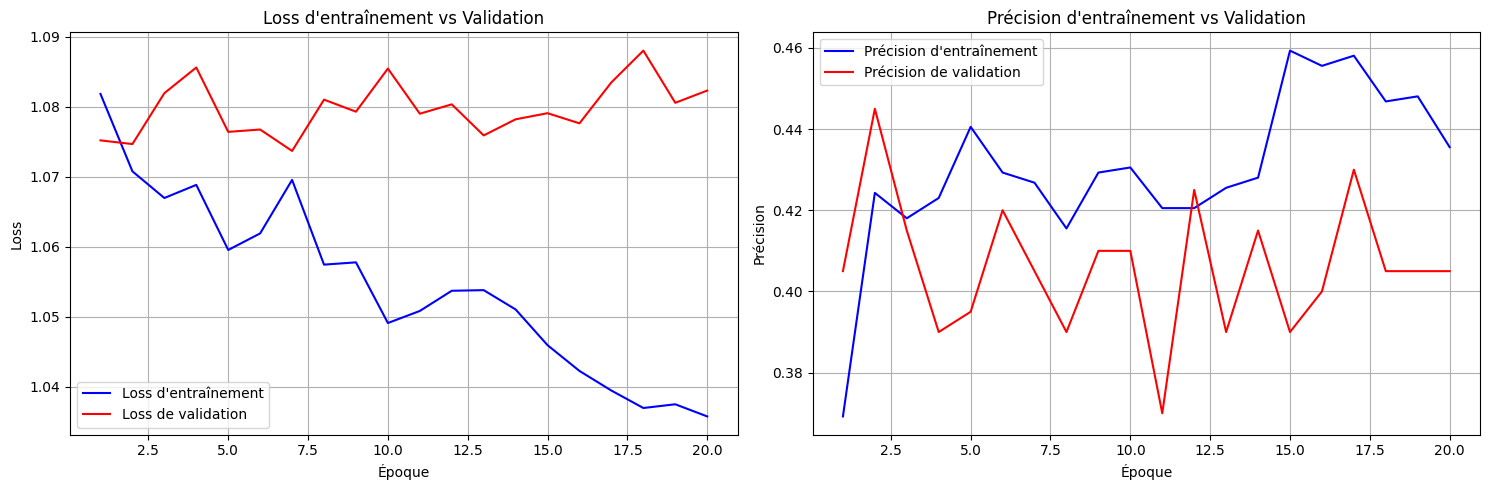

In [145]:
# Visualisation des courbes d'entraînement
plt.figure(figsize=(15, 5))

# Courbes de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Loss d\'entraînement')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Loss de validation')
plt.title('Loss d\'entraînement vs Validation')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Courbes de précision
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Précision d\'entraînement')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Précision de validation')
plt.title('Précision d\'entraînement vs Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()